<a href="https://colab.research.google.com/github/andrewchoi82/ASL-Classification-CAIS-/blob/main/Alphabet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ASL Alphabet Classification**

In [ ]:
# Import necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/CAIS++/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
#change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

## **Loading Data**
Here, we will load the dataset by simply downloading it from Pytorch.

In [ ]:
! kaggle datasets download grassknoted/asl-alphabet

100% 1.02G/1.03G [00:08<00:00, 153MB/s]
100% 1.03G/1.03G [00:08<00:00, 134MB/s]


In [ ]:
!mkdir ./data

In [ ]:
! unzip asl-alphabet.zip

In [ ]:
!mv ./asl_alphabet_test ./data

In [ ]:
!mv ./asl_alphabet_train/asl_alphabet_train ./data

In [ ]:
data_dir = '/content/data/asl_alphabet_train'

# Transform the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset and split it into training and testing sets
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# 0.8 split ratio
total_samples = (len(full_dataset))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size


# Split the dataset into training and testing sets
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders for training and testing
data_loaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4),
}
# Get class names
class_names = full_dataset.classes

# Get the size of the datasets
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualizing images from the dataset!




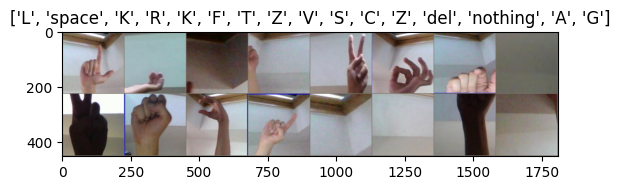

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# load the resnet 18 model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Output sample size is 29 for all the letters and the space del and nothing
model_ft.fc = nn.Linear(num_ftrs, 29)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


## **Define Training Function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #TODO-----------
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## **Training and Evaluating**

In [ ]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)



Epoch 0/2
----------
train Loss: 0.6766 Acc: 0.8124
test Loss: 0.3432 Acc: 0.8947

Epoch 1/2
----------
train Loss: 0.3454 Acc: 0.8955
test Loss: 0.2721 Acc: 0.9147

Epoch 2/2
----------
train Loss: 0.2965 Acc: 0.9084
test Loss: 0.2313 Acc: 0.9252

Training complete in 24m 18s
Best val Acc: 0.925172


## **Define Visualization Function**
Here, we will define the function to visualize predictions that the model makes.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

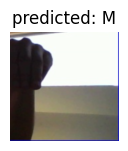

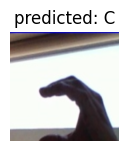

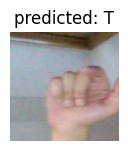

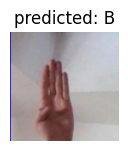

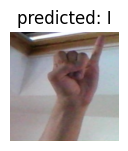

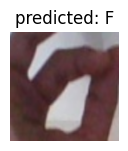

In [ ]:
visualize_model(model_ft)